In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
import fastai.vision.all as vision
import fastbook as fastb
import matplotlib
import torch

matplotlib.rc('image', cmap='Greys')

In [3]:
torch.cuda.is_available()

True

In [4]:
print(fastb.URLs.MNIST_SAMPLE)

https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz


In [5]:
# /root/.fastai/data/mnist_sample
path = vision.untar_data(fastb.URLs.MNIST_SAMPLE)
print(path)

/root/.fastai/data/mnist_sample


In [6]:
train_3_paths = (path/'train'/'3').ls().sorted()
train_7_paths = (path/'train'/'7').ls().sorted()

In [7]:
# list of tensors
# fastb.Image is the same as PIL.Image
# fastb.tensor is like torch.tensor() but also handles vector elements
train_3_list = [fastb.tensor(fastb.Image.open(o)) for o in train_3_paths]
train_7_list = [fastb.tensor(fastb.Image.open(o)) for o in train_7_paths]

In [8]:
train_3_tns = torch.stack(train_3_list)
train_7_tns = torch.stack(train_7_list)

In [9]:
def normalize_pix_values(x_tns):
    max_val = torch.max(x_tns.view((-1,)) ).float().item()
    min_val = torch.min(x_tns.view((-1,)) ).float().item()
    print (f"(min, max) = ( {min_val},{max_val} )")
    scaled_x = (1.0/(max_val-min_val)) * (x_tns - min_val)
    return scaled_x

In [10]:
#
# scale image values to [0..1]
train_3_tns = normalize_pix_values(train_3_tns)
train_7_tns = normalize_pix_values(train_7_tns)

max_val = torch.max( train_3_tns.view((-1,)) ).float().item()
min_val = torch.min( train_3_tns.view((-1,)) ).float().item()
assert max_val==1.0
assert min_val==0.0

(min, max) = ( 0.0,255.0 )
(min, max) = ( 0.0,255.0 )


<AxesSubplot:>

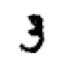

In [11]:
fastb.show_image(train_3_tns[0,:,:])

torch.Size([12396, 784])


<AxesSubplot:>

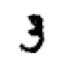

In [12]:
#
# training set
# reshape each 28*28 image into a vector of 28*28 values
train_x = torch.cat( [train_3_tns, train_7_tns] ).view(-1, 28*28)

print(train_x.shape)
fastb.show_image( train_x[0,:].view(28,28) )   # one image per row

In [13]:
# make label tensor
# 1 : 3 image
# 0 : 7 image
train_y = torch.cat( ( torch.ones( (len(train_3_list),)), torch.zeros((len(train_7_list),) ) ) )
print(train_y.shape)
assert train_y.shape[0]==train_x.shape[0]



torch.Size([12396])


In [14]:
#
# use list( zip( (x, y) )) to make a list of interleaved [ (x0,y1), (x1, y1), ...]
# because zip() is an iterator, you must use list( zip() ) -- cannot use [ zip() ]
list( zip([1,2,3],[4,5,6]) )

[(1, 4), (2, 5), (3, 6)]

In [15]:
#
# make a training dataset = [ (x0,y0), (x1, y1), ...]
train_dset = list(zip(train_x, train_y))


In [16]:
# repeat the above steps to
# make the validation training dataset
valid_3_paths = (path/'valid'/'3').ls().sorted()
valid_7_paths = (path/'valid'/'7').ls().sorted()

valid_3_list = [fastb.tensor(fastb.Image.open(o)) for o in valid_3_paths]
valid_7_list = [fastb.tensor(fastb.Image.open(o)) for o in valid_7_paths]

valid_3_tns = torch.stack(valid_3_list)
valid_7_tns = torch.stack(valid_7_list)

valid_3_tns = normalize_pix_values(valid_3_tns)
valid_7_tns = normalize_pix_values(valid_7_tns)

valid_x = torch.cat([valid_3_tns, valid_7_tns]).view(-1,28*28)
valid_y = torch.tensor([1]*len(valid_3_list) + [0]*len(valid_7_list)).unsqueeze(1)

valid_dset = list(zip(valid_x, valid_y))
print(len(valid_dset))

(min, max) = ( 0.0,255.0 )
(min, max) = ( 0.0,255.0 )
2038


In [17]:
#
# linear_model encapsulates weights and prediction via matmul
# (also initializes the weights randomly?)
#
# prediction is computed like this:
# y = mymodel(x)
torch.manual_seed(0)  # make results reproducible
mymodel=torch.nn.Linear(28*28,1)

w, b = mymodel.parameters()
print(w.shape)
print(b.shape)
print(w.mean())


torch.Size([1, 784])
torch.Size([1])
tensor(-9.7257e-05, grad_fn=<MeanBackward0>)


In [18]:
#
# DataLoader is an iterator which returns batches of x,y
train_dl = fastb.DataLoader(train_dset, batch_size=256, shuffle=False)
xb,yb=fastb.first(train_dl) # first() is a silly fcn to look at first entry of iterator; part of fastcore
print([xb.shape, yb.shape])

valid_dl = fastb.DataLoader(valid_dset, batch_size=256)

[torch.Size([256, 784]), torch.Size([256])]


In [19]:
import hashlib
def tensor_to_hash(t):
    b0 = xb.numpy().tobytes()
    h0 = hashlib.md5(b0).hexdigest()
    return h0

In [20]:
for n, d in enumerate(train_dl):
    xb,yb = d
    print(f"{n} : {tensor_to_hash(xb)}")

0 : 8c22067c43f16e652fe4dcd196b689c6
1 : c0169deecd8909989c175f3383632658
2 : 79d2e6ae8a71ca782c02c18272e2e5dd
3 : 68ec55c6eda682253503865f6364bfa3
4 : 3b583075582c6aa10b394bc2d9772857
5 : f1398bf9e288b70eaf110833d2c948aa
6 : 3b7b047fe6335426977c19a319298631
7 : cd72082f3ee1865ce469bab725c626cc
8 : 1cf51e71ca138fbb2c9c0880ec90116a
9 : 866cc66b24d6f053444caed8fedf4f7d
10 : 22858f3945b729463d9a853299207b9a
11 : 516de0a216f526f174159633c694e4fa
12 : 26f8616c7cc1a17052466427eb710cc4
13 : 73c2faa1fb2e991f1834d0beb3303e2b
14 : 962088ffccb5ef03a1d1b1ff8a15ccbf
15 : 9fe6653891fcac5868f4d2f7d851e394
16 : 9b421d9cc6d9a57f197fa92fb65b545c
17 : 400c1af77c89487deb8fc940dbf2ed19
18 : 084777ba659ca7518fe7b96efe49e364
19 : ff255f8d3130382829351915efb23ba0
20 : edb334324d4e0ce696b8a2bc4159df75
21 : 51c1a59126f7c45d6c6dfca115e34842
22 : cfa5b3982e42244b7b64ff33e7ee366b
23 : f6dfa5d7ecaa7253ad647fb4a68c8f72
24 : 98d69c8ace7d5dfadfa4e3fe721fb45d
25 : 87c02933b60da500b9769bf2a69b08ba
26 : 8b1f5c420588b03f6

In [21]:
#
# train_dset is a list of tuples [(x,y),...]
#
print(train_dset[0][0].shape)
y = mymodel(train_dset[3][0])
#y.requires_grad==True


torch.Size([784])


In [22]:
class BasicOptim:
    def __init__(self, params, learnrate):
        self.param_list = list(params)  # NOTE: convert iterator into list!
        self.learnrate = learnrate
        
    def step(self, *args, **kwargs):
        assert len(self.param_list)==2
        for n, param in enumerate(self.param_list):
            #print(f"step {n}: grad = {torch.sum(param.grad)}")
            param.data -= param.grad.data * self.learnrate
        #
    
    def zero_grad(self, *args, **kwargs):
        for param in self.param_list:
            param.grad = None
        

In [23]:
def mnist_loss(predictions, targets):
    #
    # compare predictions to known results ("targets")
    # return mean score
    predictions = predictions.sigmoid()  # confines result to [0..1]
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [24]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model, valid_dl):
    #
    # return batch accuracy metric
    accuracy_l = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    #print(f"accuracy list: {accuracy_l}")
    return round(torch.stack(accuracy_l).mean().item(), 4)

In [25]:
# do a single prediction
# expected weight sums:
#   tensor(-0.0762, grad_fn=<SumBackward0>)   # weights
#   tensor([-0.0198], requires_grad=True)   # bias
# expected torch.sum(batch[0,:]))
#   tensor(111.9529)
# expected predictions:
#   tensor([[ 0.2755],
#            [ 0.0127],
#            [ 0.2574],
#            [-0.0040]], grad_fn=<AddmmBackward0>)

torch.manual_seed(0)  # make results reproducible
mymodel=torch.nn.Linear(28*28,1)
batch = train_x[:4]

#print(torch.sum(batch[0,:]))
#for p in mymodel.parameters():
#    print(torch.sum(p))
preds = mymodel(batch)
#print(preds)
metric = validate_epoch(mymodel, valid_dl)
print(f"validate_epoch() = {metric}")
assert metric==0.419   # from 04_mnist_basics.ipynb notebook

validate_epoch() = 0.419


In [32]:
#
# perform 1 epoch of training on batch data
#
torch.manual_seed(0)  # make results reproducible
mymodel=torch.nn.Linear(28*28,1)

w, b = mymodel.parameters()
print(f"initial weight sum = {torch.sum(w)}")

myopt = BasicOptim(mymodel.parameters(), 1.0)
for n, d in enumerate(train_dl):
    #print(f"batch {n} ")
    xb, yb = d
    #
    # compute predictions and gradient
    preds = mymodel(xb)
    loss = mnist_loss(preds, yb)
    #print(f"pre  loss = {loss}")
    loss.backward()   # gradient results appears in model.parameters
    #print(">>> step")
    myopt.step()
    #print("<<< step")
    
    # rerun prediction and print updated loss
    #preds = mymodel(xb)
    #loss = mnist_loss(preds, yb)
    #print(f"post loss = {loss}")
    
    myopt.zero_grad()
#
print("")
metric = validate_epoch(mymodel, valid_dl)
print(f"validate_epoch() = {metric}")


initial weight sum = -0.07624934613704681

validate_epoch() = 0.4932


In [35]:
def train_epoch(model, optimizer, dloader):
    #
    # train over all minibatches in the dataloader
    #
    for n, d in enumerate(dloader):
        xb,yb = d
        #print(f"{n} ",end='')
        #
        # compute predictions and gradient
        print(".",end='')
        preds = model(xb)
        loss = mnist_loss(preds, yb)
        #print(f"pre loss = {loss}")
        loss.backward()   # gradient results appears in model.parameters
        
        optimizer.step()
        optimizer.zero_grad()
    #
    print()
    


In [36]:
#
# train for 1 epoch
torch.manual_seed(0)  # make results reproducible
mymodel=torch.nn.Linear(28*28,1)
myopt = BasicOptim(mymodel.parameters(), 1.0)

train_epoch(mymodel, myopt, train_dl)

metric = validate_epoch(mymodel, valid_dl)
print(f"validate_epoch() = {metric}")
#assert metric==0.4932

.................................................
validate_epoch() = 0.4932


In [50]:
#
# train for N epochs
#
torch.manual_seed(0)  # make results reproducible
mymodel=torch.nn.Linear(28*28,1)
myopt = BasicOptim(mymodel.parameters(), 1.0)

N=10
for n in range(N):
    print(f"{n} ====")
    print("train_epoch")
    train_epoch(mymodel, myopt, train_dl)
    
    metric = validate_epoch(mymodel, valid_dl)
    print(f"validate_epoch() = {metric}")


0 ====
train_epoch
.................................................
validate_epoch() = 0.4932
1 ====
train_epoch
.................................................
validate_epoch() = 0.8389
2 ====
train_epoch
.................................................
validate_epoch() = 0.8306
3 ====
train_epoch
.................................................
validate_epoch() = 0.9102
4 ====
train_epoch
.................................................
validate_epoch() = 0.9346
5 ====
train_epoch
.................................................
validate_epoch() = 0.9463
6 ====
train_epoch
.................................................
validate_epoch() = 0.9555
7 ====
train_epoch
.................................................
validate_epoch() = 0.9614
8 ====
train_epoch
.................................................
validate_epoch() = 0.9663
9 ====
train_epoch
.................................................
validate_epoch() = 0.9678


In [53]:
dls = fastb.DataLoaders(train_dl, valid_dl)
torch.manual_seed(0)  # make results reproducible

learn = fastb.Learner(dls, 
                      torch.nn.Linear(28*28,1),  # same as mymodel
                      opt_func=fastb.SGD, # same as BasicOptimizer
                      loss_func=mnist_loss,
                      metrics=batch_accuracy)
learn.fit(10,lr=1.0)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636849,0.503612,0.495584,00:00
1,0.567227,0.190596,0.838077,00:00
2,0.208741,0.184873,0.829735,00:00
3,0.091478,0.108047,0.909715,00:00
4,0.048400,0.078212,0.934249,00:00
5,0.031685,0.062351,0.946025,00:00
6,0.024854,0.052594,0.955348,00:00
7,0.021827,0.046159,0.961236,00:00
8,0.020296,0.041660,0.966143,00:00
9,0.019379,0.038354,0.967615,00:01
